In [1]:
# Standard library imports
import csv
import itertools
import os
import os.path
import random
from glob import glob
from pathlib import Path
import zlib
import importlib

# Third-party imports
import cv2
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import skimage
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from skimage.transform import resize
from sklearn import model_selection
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import (KFold, StratifiedKFold, cross_val_score,
                                     learning_curve, train_test_split)
from sklearn.utils import class_weight, shuffle
from tqdm import tqdm

# Keras-specific imports
import keras
from keras import backend as K
from keras import layers, models, optimizers
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import (Activation, AveragePooling2D, BatchNormalization,
                          Conv2D, Dense, Dropout, Flatten, Lambda, MaxPool2D,
                          MaxPooling2D)
from keras.models import Model, Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.utils import to_categorical
import tensorflow as tf


Matplotlib is building the font cache; this may take a moment.


In [2]:

# Custom imports
import fit
import evaluate
import viz

%matplotlib inline

In [3]:
imageSize=50
train_dir = "/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/archive/asl_alphabet_train/asl_alphabet_train"
test_dir =  "/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/archive/asl_alphabet_test/asl_alphabet_test"

def get_data(folder):
    # Load data and labels from parent folder
    X = []
    y = []
    for folderName in os.listdir(folder):
        full_path = os.path.join(folder, folderName)  # Create full path to the item
        if os.path.isdir(full_path):  # Check if the item is a directory
            if not folderName.startswith('.'):
                if folderName in ['A']:
                    label = 0
                elif folderName in ['B']:
                    label = 1
                elif folderName in ['C']:
                    label = 2
                elif folderName in ['D']:
                    label = 3
                elif folderName in ['E']:
                    label = 4
                elif folderName in ['F']:
                    label = 5
                elif folderName in ['G']:
                    label = 6
                elif folderName in ['H']:
                    label = 7
                elif folderName in ['I']:
                    label = 8
                elif folderName in ['J']:
                    label = 9
                elif folderName in ['K']:
                    label = 10
                elif folderName in ['L']:
                    label = 11
                elif folderName in ['M']:
                    label = 12
                elif folderName in ['N']:
                    label = 13
                elif folderName in ['O']:
                    label = 14
                elif folderName in ['P']:
                    label = 15
                elif folderName in ['Q']:
                    label = 16
                elif folderName in ['R']:
                    label = 17
                elif folderName in ['S']:
                    label = 18
                elif folderName in ['T']:
                    label = 19
                elif folderName in ['U']:
                    label = 20
                elif folderName in ['V']:
                    label = 21
                elif folderName in ['W']:
                    label = 22
                elif folderName in ['X']:
                    label = 23
                elif folderName in ['Y']:
                    label = 24
                elif folderName in ['Z']:
                    label = 25
                elif folderName in ['del']:
                    label = 26
                elif folderName in ['nothing']:
                    label = 27
                elif folderName in ['space']:
                    label = 28           
                else:
                    label = 29
                for image_filename in tqdm(os.listdir(full_path)):
                    img_file = cv2.imread(os.path.join(full_path, image_filename))
                    if img_file is not None:
                        img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                        img_arr = np.asarray(img_file)
                        X.append(img_arr)
                        y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [5]:

X_train, Y_train = get_data(train_dir)

X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, shuffle=True, random_state=23) 

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=23) 


Y_trainHot = to_categorical(Y_train, num_classes = 30)

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_trainHot = to_categorical(y_train, num_classes = 30)
y_testHot = to_categorical(y_test, num_classes = 30)
y_valHot = to_categorical(y_val, num_classes = 30)

100%|██████████| 3000/3000 [00:35<00:00, 85.65it/s] 


In [6]:
# shuffle since data was loaded in order of class

X_train, y_trainHot = shuffle(X_train, y_trainHot, random_state=13)
X_test, y_testHot = shuffle(X_test, y_testHot, random_state=13)
X_val, y_valHot = shuffle(X_test, y_testHot, random_state=13)

# X_train = X_train[:30000]
# X_test = X_test[:30000]
# y_trainHot = y_trainHot[:30000]
# y_testHot = y_testHot[:30000]

labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "delete", "nothing", "space"]


In [7]:
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_train.npy', X_train)
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_test.npy', X_test)
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_trainHot.npy', y_trainHot)
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_testHot.npy', y_testHot)
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_train.npy', y_train)
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_test.npy', y_test)


np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_val.npy', X_val)
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_val.npy', y_val)
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_valHot.npy', y_valHot)

In [20]:
importlib.reload(fit)

<module 'fit' from '/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/signvision-ai/src/fit.py'>

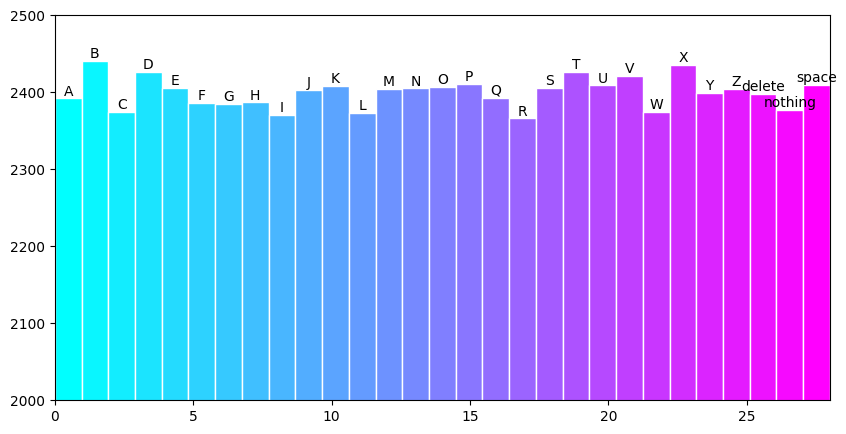

In [9]:
viz.distPlot(y_train, labels)

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [11]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1))
X_val_scaled = scaler.transform(X_val.reshape(X_test.shape[0], -1))

In [12]:
# # Apply PCA
# pca = PCA(n_components=0.95)  # Keep 95% of variance
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)
# X_val_pca = pca.transform(X_val_scaled)

In [13]:
# np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_train_pca.npy', X_train_pca)
# np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_test_pca.npy', X_test_pca)
# np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_val_pca.npy', X_val_pca)

In [14]:
# # Explained variance plot
# plt.figure(figsize=(10, 5))
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('Number of components')
# plt.ylabel('Cumulative explained variance')
# plt.title('Explained variance by different principal components')
# plt.grid(True)
# plt.show()

In [15]:
X_test_pca = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_test_pca.npy")
y_test = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_test.npy")
y_testHot = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_testHot.npy")
X_test = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_test.npy")
X_val = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_val.npy")
y_val = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_val.npy")
X_train = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_train.npy")
y_train = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_train.npy")
y_trainHot = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_trainHot.npy")
y_valHot = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_valHot.npy")

In [24]:
mapping = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'}
classes = np.unique(y_train)

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {classes[i]: class_weights[i] for i in range(len(classes))}

weight_path = '../keras_pre-trained_models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
# weight_path2 = 'keras_pre-trained_models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained = VGG16(weights=weight_path, include_top=False, input_shape=(imageSize, imageSize, 3))
# pretrained_model_2 = InceptionV3(weights = weight_path2, include_top=False, input_shape=(imageSize, imageSize, 3))
optimizer1 = keras.optimizers.Adam()
# optimizer2 = keras.optimizers.RMSprop(lr=0.0001)

In [26]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

In [27]:
importlib.reload(fit)

<module 'fit' from '/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/signvision-ai/src/fit.py'>

In [28]:
# history1, model1 = fit.scaled1dNetwork(X_train_pca, y_trainHot, X_val_pca, y_valHot,class_weight_dict,30,20,optimizer1)

In [30]:
history, model = fit.pretrainedNetwork(X_train, y_trainHot, .2,pretrained,weight_path,class_weight_dict,30,10,optimizer1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 50, 50, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │        15,390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,730,078 (56.19 MB)

 Trainable params: 15,390 (60.12 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 600s 344ms/step - accuracy: 0.6010 - loss: 1.8467 - val_accuracy: 0.7670 - val_loss: 1.2096
Epoch 2/10
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 597s 343ms/step - accuracy: 0.7997 - loss: 1.0000 - val_accuracy: 0.8277 - val_loss: 0.8378
Epoch 3/10
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 647s 372ms/step - accuracy: 0.8503 - loss: 0.7390 - val_accuracy: 0.8677 - val_loss: 0.6564
Epoch 4/10
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 646s 371ms/step - accuracy: 0.8806 - loss: 0.5946 - val_accuracy: 0.8920 - val_loss: 0.5418
Epoch 5/10
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 752s 432ms/step - accuracy: 0.9000 - loss: 0.5014 - val_accuracy: 0.9068 - val_loss: 0.4652
Epoch 6/10
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 568s 326ms/step - accuracy: 0.9142 - loss: 0.4345 - val_accuracy: 0.9158 - val_loss: 0.4150
Epoch 7/10
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 496s 285ms/step - accuracy: 0.9247 - loss: 0.3848 - val_accuracy: 0.9287 - val_loss: 0.3666
Epoch 8/10
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 466s 268ms/step - ac

In [ ]:
# model1.save('assets/models/ASL_DNN_1D.keras')
# model1.save("assets/models/ASL_DNN_1D.h5")

In [33]:

model.save('../streamlit_app/assets/models/ASL_DNN_3D.keras')
model.save("../streamlit_app/assets/models/ASL_DNN_3D.h5")

In [ ]:
# model1.predict(np.expand_dims(X_val_pca[0], axis=0))

In [ ]:
# from sklearn.metrics import accuracy_score

# # Predict the classes for the 1D test set
# y_pred1DHot = model1.predict(X_test_pca)

# # If the predictions are probabilities (as with some models), 
# # you'll need to convert to predicted class labels by taking the argmax
# if y_pred1DHot.ndim > 1:
#     y_pred1D = np.argmax(y_pred1DHot, axis=1)

# # Ensure 'y_test' is not one-hot encoded. If it is, convert it:
# if y_testHot.ndim > 1:
#     y_test1D = np.argmax(y_testHot, axis=1)

# # Calculate the accuracy score
# accuracy = accuracy_score(y_test1D, y_pred1D)

# print(f"Accuracy score: {accuracy}")


In [ ]:
# from sklearn.metrics import classification_report
# print('\n', classification_report(np.where(y_testHot > 0)[1], np.argmax(model1.predict(X_test_pca), axis=1), target_names=labels), sep='') 

In [ ]:
# def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
#     # Compute confusion matrix
#     cm = confusion_matrix(y_true, y_pred)
#     print(cm)

#     # Export to CSV
#     np.savetxt('confusion_matrix.csv', cm, delimiter=',', fmt='%d')


#     fig, ax = plt.subplots(1,1,figsize=(10, 10))
#     im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
#     # ax.figure.colorbar(im, ax=ax)
#     # Show all ticks and label them with the respective list entries
#     ax.set(xticks=np.arange(cm.shape[1]),
#            yticks=np.arange(cm.shape[0]),
#            xticklabels=classes, yticklabels=classes,
#            title=title,
#            ylabel='True label',
#            xlabel='Predicted label')
    
#     # Rotate the tick labels and set their alignment.
#     plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#              rotation_mode="anchor")
    
#     # Loop over data dimensions and create text annotations.
#     fmt = 'd'
#     thresh = cm.max() / 2.
#     for i in range(cm.shape[0]):
#         for j in range(cm.shape[1]):
#             ax.text(j, i, format(cm[i, j], fmt),
#                     ha="center", va="center",
#                     color="white" if cm[i, j] > thresh else "black")
#     fig.tight_layout()
#     return ax

# # Predict classes on the test set
# y_pred_prob = model1.predict(X_test_pca)
# y_pred = np.argmax(y_pred_prob, axis=1)
# y_true = np.argmax(y_testHot, axis=1)  # Assuming ytest is one-hot encoded

# # Assuming you have a list of class names as 'class_names'
# plot_confusion_matrix(y_true, y_pred, classes=labels)

# plt.show()

In [37]:
# Predict the classes for the 3D test set
y_pred3D = model.predict(X_test)

# If the predictions are probabilities (as with some models), 
# you'll need to convert to predicted class labels by taking the argmax
if y_pred3D.ndim > 1:
    y_pred3D = np.argmax(y_pred3D, axis=1)

# Ensure 'y_test' is not one-hot encoded. If it is, convert it:
if y_test.ndim > 1:
    y_test3D = np.argmax(y_test, axis=1)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred3D)

print(f"Accuracy score: {accuracy}")


272/272 ━━━━━━━━━━━━━━━━━━━━ 44s 160ms/step
Accuracy score: 0.03333333333333333


In [ ]:

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred3D)

print(f"Accuracy score: {accuracy}")


In [ ]:
# evaluate.evaluate(model1, history1, X_test, y_testHot, mapping)